In [3]:
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch import optim

from tqdm import tqdm

In [2]:
batch_size = 1000

In [3]:
# 生成卷积操作时需要的两列数据的组合的列表
def generate_combination(N):
    """
    args:
        N: int, the number of rows of the matrix

    return:
        combination: list, the combination of two columns of the matrix
        combination_rev: list, the combination of two rows of the matrix, which is the reverse of combination
    """
    col = []
    col_rev = []
    for i in range(1,N):
        for j in range(0,i):
            col.append([i,j])
            col_rev.append([j,i])
    return col, col_rev
# 生成卷积操作时需要的两列数据的组合的列表
combination, combination_rev = generate_combination(9)

# 根据输入的矩阵和卷积操作的步长, 计算卷积操作的索引
def get_index_list(matrix, stride):
    """
    args:
        matrix: torch.tensor, the input matrix
        stride: int, the stride of the convolution operation
    
    return:
        index_list: list, the index of the convolution operation

    """
    W = matrix.shape[3]
    if W % stride == 0:
        index_list = list(np.arange(0, W+stride, stride))
    else:
        mod = W % stride
        index_list = list(np.arange(0, W+stride-mod, stride)) + [W]
    return index_list
# 根据输入的矩阵和卷积操作的步长, 计算卷积操作的索引
# inception1模块使用的卷积操作的步长为10
index_list_1 = get_index_list(np.zeros((1,1,9,30)), 10)
# inception2模块使用的卷积操作的步长为3
index_list_2 = get_index_list(np.zeros((1,1,9,30)), 3)

In [4]:
class GRU(nn.Module):
    def __init__(self):
        super(GRU, self).__init__()
        self.gru = nn.GRU(input_size=117, hidden_size=30,
                          num_layers=2, batch_first=True, bidirectional=False)

    def forward(self, data):
        # N*time_step*117 -> output: torch.Size([1000, time_step, 30]), hn: torch.Size([2, 1000, 30]), 对于Inception1, time_step=3, 对于Inception2, time_step=10
        output, hn = self.gru(data)
        h = hn[-1:] # 使用最后一层hidden state的输出, h: torch.Size([1, 1000, 30])
        data = h.squeeze(0) # torch.Size([1000, 30])
        return data  # torch.Size([1000, 30])


In [5]:
class Inception(nn.Module):
    """
    Inception, 用于提取时间序列的特征, 具体操作包括：

    1. kernel_size和stride为d=10或3的特征提取层, 类似于卷积层，用于提取时间序列的特征. 具体包括:(下面以d=10为例)

        1. ts_corr4d: 过去 d 天 X 值构成的时序数列和 Y 值构成的时序数列的相关系数
        2. ts_cov4d: 过去 d 天 X 值构成的时序数列和 Y 值构成的时序数列的协方差
        3. ts_stddev4d: 过去 d 天 X 值构成的时序数列的标准差
        4. ts_zscore4d: 过去 d 天 X 值构成的时序数列的平均值除以标准差
        5. ts_return4d: (X - delay(X, d))/delay(X, d)-1, 其中delay(X, d)为 X 在 d 天前的取值
        6. ts_decaylinear4d: 过去 d 天 X 值构成的时序数列的加权平均值，权数为 d, d – 1, …, 1(权数之和应为 1，需进行归一化处理)，其中离现在越近的日子权数越大
        7. ts_mean4d: 过去 d 天 X 值构成的时序数列的平均值

        各操作得到的张量维数：
        1. 由于涉及两个变量的协方差, 因此ts_corr4d和ts_cov4d的输出为 N*1*36*3
        2. 其余操作均只涉及单变量的时序计算, 因此输出为 N*1*9*3

    2. 对第1步的输出进行Batch Normalization操作, 输出维数仍为 N*1*36*3 或 N*1*9*3

    3. 对第2步的输出, 在 H 维度上拼接, 输出维数为 N*1*(2*36+5*9)*3 = N*1*117*3

    4. 对第3步的输出, 使用GRU进行特征提取, 输出维数为 N*30

    """

    def __init__(self, combination, combination_rev, index_list):
        """
        combination: 卷积操作时需要的两列数据的组合
        combination_rev: 卷积操作时需要的两列数据的组合, 与combination相反
        index_list: 卷积操作时需要的时间索引
        
        """

        super(Inception, self).__init__()
        # 卷积操作时需要的两列数据的组合
        self.combination = combination
        self.combination_rev = combination_rev

        # 卷积操作时需要的时间索引
        self.index_list = index_list

        # 卷积操作后的Batch Normalization层
        self.bc1 = nn.BatchNorm2d(1)
        self.bc2 = nn.BatchNorm2d(1)
        self.bc3 = nn.BatchNorm2d(1)
        self.bc4 = nn.BatchNorm2d(1)
        self.bc5 = nn.BatchNorm2d(1)
        self.bc6 = nn.BatchNorm2d(1)
        self.bc7 = nn.BatchNorm2d(1)

        # GRU层
        self.GRU = GRU()

    def forward(self, data):
        """
        data: 输入的数据, 维度为batch_size*1*9*30

        """
        # 本层的输入为batch_size*1*9*30, 在训练时不需要反向传播, 因此可以使用detach()函数
        data = data.detach().cpu().numpy()
        combination = self.combination
        combination_rev = self.combination_rev

        # 卷积操作
        conv1 = self.ts_corr4d(data, combination, combination_rev).to(torch.float)
        conv2 = self.ts_cov4d(data, combination, combination_rev).to(torch.float)
        conv3 = self.ts_stddev4d(data).to(torch.float)
        conv4 = self.ts_zcore4d(data).to(torch.float)
        conv5 = self.ts_return4d(data).to(torch.float)
        conv6 = self.ts_decaylinear4d(data).to(torch.float)
        conv7 = self.ts_mean4d(data).to(torch.float)

        # 卷积操作后的Batch Normalization
        batch1 = self.bc1(conv1)
        batch2 = self.bc2(conv2)
        batch3 = self.bc3(conv3)
        batch4 = self.bc4(conv4)
        batch5 = self.bc5(conv5)
        batch6 = self.bc6(conv6)
        batch7 = self.bc7(conv7)

        # 在 H 维度上进行特征拼接
        feature = torch.cat(
            [batch1, batch2, batch3, batch4, batch5, batch6, batch7], axis=2)  # N*1*(2*36+5*9)*3 = N*1*117*3

        # GRU层
        feature = feature.squeeze(1)  # N*1*117*3 -> N*117*3
        feature = feature.permute(0, 2, 1)  # N*117*3 -> N*3*117
        feature = self.GRU(feature)  # N*3*117 -> N*30

        return feature

    # 过去 d 天 X 值构成的时序数列和 Y 值构成的时序数列的相关系数
    def ts_corr4d(self, Matrix, combination, combination_rev):
        new_H = len(combination)
        index_list = self.index_list
        list = []  # 存放长度为len(index_list)-1的相关系数
        for i in range(len(index_list)-1):
            start_index = index_list[i]
            end_index = index_list[i+1]
            data = Matrix[:, :, combination, start_index:end_index]  # N*1*new_H*2*d
            data2 = Matrix[:, :, combination_rev,
                           start_index:end_index]  # N*1*new_H*2*d
            std1 = data.std(axis=4, keepdims=True)  # N*1*new_H*2*1, 在时序上求标准差
            std2 = data2.std(axis=4, keepdims=True)  # N*1*new_H*2*1, 在时序上求标准差
            std = (std1*std2).mean(axis=3, keepdims=True)  # N*1*new_H*1*1
            list.append(std)
        std = np.squeeze(np.array(list)).transpose(1, 2, 0).reshape(-1, 1, new_H,
                                                                    len(index_list)-1)+0.01  # N*1*new_H*len(index_list)-1 # 加上0.01, 防止除0
        # N*1*new_H*len(index_list)-1
        cov = self.ts_cov4d(Matrix, combination, combination_rev)
        corr = cov/std  # N*1*new_H*len(index_list)-1
        return corr

    # 过去 d 天 X 值构成的时序数列和 Y 值构成的时序数列的协方差
    def ts_cov4d(self, Matrix, combination, combination_rev):
        new_H = len(combination)
        index_list = self.index_list
        list = []  # 存放长度为len(index_list)-1的协方差
        for i in range(len(index_list)-1):
            start_index = index_list[i]
            end_index = index_list[i+1]
            data = Matrix[:, :, combination, start_index:end_index]  # N*1*new_H*2*d
            data2 = Matrix[:, :, combination_rev,
                           start_index:end_index]  # N*1*new_H*2*d
            mean1 = data.mean(axis=4, keepdims=True)  # N*1*new_H*2*1, 在时序上求均值
            mean2 = data2.mean(axis=4, keepdims=True)  # N*1*new_H*2*1, 在时序上求均值
            spread1 = data - mean1  # N*1*new_H*2*d, 在时序上求偏差
            spread2 = data2 - mean2  # N*1*new_H*2*d, 在时序上求偏差
            cov = ((spread1 * spread2).sum(axis=4, keepdims=True) /
                   (data.shape[4]-1)).mean(axis=3, keepdims=True)  # N*1*new_H*1*1
            list.append(cov)
        cov = np.squeeze(np.array(list)).transpose(
            1, 2, 0).reshape(-1, 1, new_H, len(index_list)-1)  # N*1*new_H*len(index_list)-1
        return torch.from_numpy(cov)

    # 过去 d 天 X 值构成的时序数列的标准差
    def ts_stddev4d(self, Matrix):
        # 只需要对单变量做卷积操作, 不需要将变量两两组合。因此输出的 H 可以保持和输入的 H 一致
        new_H = Matrix.shape[2]
        index_list = self.index_list
        list = []  # 存放长度为len(index_list)-1的标准差
        for i in range(len(index_list)-1):
            start_index = index_list[i]
            end_index = index_list[i+1]
            data = Matrix[:, :, :, start_index:end_index]  # N*1*H*d
            std = data.std(axis=3, keepdims=True)  # N*1*H*1
            list.append(std)
        std4d = np.squeeze(np.array(list)).transpose(
            1, 2, 0).reshape(-1, 1, new_H, len(index_list)-1)  # N*1*new_H*len(index_list)-1
        return torch.from_numpy(std4d)

    # 过去 d 天 X 值构成的时序数列的平均值除以标准差
    def ts_zcore4d(self, Matrix):
        # 只需要对单变量做卷积操作, 不需要将变量两两组合。因此输出的 H 可以保持和输入的 H 一致
        new_H = Matrix.shape[2]
        index_list = self.index_list
        list = []  # 存放长度为len(index_list)-1的zcore
        for i in range(len(index_list)-1):
            start_index = index_list[i]
            end_index = index_list[i+1]
            data = Matrix[:, :, :, start_index:end_index]  # N*1*H*d
            mean = data.mean(axis=3, keepdims=True)  # N*1*H*1
            std = data.std(axis=3, keepdims=True) + \
                0.01  # N*1*H*1, 加上0.01, 防止除以0
            list.append(mean/std)
        zscore = np.squeeze(np.array(list)).transpose(
            1, 2, 0).reshape(-1, 1, new_H, len(index_list)-1)  # N*1*new_H*len(index_list)-1
        return torch.from_numpy(zscore)

    # (X - delay(X, d))/delay(X, d)-1, 其中 delay(X, d)为 X 在 d 天前的取值
    def ts_return4d(self, Matrix):
        # 只需要对单变量做卷积操作, 不需要将变量两两组合。因此输出的 H 可以保持和输入的 H 一致
        new_H = Matrix.shape[2]
        index_list = self.index_list
        list = []  # 存放长度为len(index_list)-1的return
        for i in range(len(index_list)-1):
            start_index = index_list[i]
            end_index = index_list[i+1]
            data = Matrix[:, :, :, start_index:end_index]  # N*1*H*d
            # N*1*H*1, 在分母加上0.01, 防止除以0
            return_ = data[:, :, :, -1]/(data[:, :, :, 0]+0.01)-1
            list.append(return_)
        ts_return = np.squeeze(np.array(list)).transpose(
            1, 2, 0).reshape(-1, 1, new_H, len(index_list)-1)  # N*1*new_H*len(index_list)-1
        return torch.from_numpy(ts_return)

    # 过去 d 天 X 值构成的时序数列的加权平均值, 权数为 d, d – 1, …, 1(权数之和应为 1, 需进行归一化处理), 其中离现在越近的日子权数越大
    def ts_decaylinear4d(self, Matrix):
        new_H = Matrix.shape[2]
        index_list = self.index_list
        list = []  # 存放长度为len(index_list)-1的加权平均值
        for i in range(len(index_list)-1):
            start_index = index_list[i]
            end_index = index_list[i+1]
            range_ = end_index-start_index
            weight = np.arange(1, range_+1)
            weight = weight/weight.sum()  # 权重向量
            data = Matrix[:, :, :, start_index:end_index]  # N*1*H*d
            wd = (data*weight).sum(axis=3, keepdims=True)  # N*1*H*1
            list.append(wd)
        ts_decaylinear = np.squeeze(np.array(list)).transpose(
            1, 2, 0).reshape(-1, 1, new_H, len(index_list)-1)  # N*1*new_H*len(index_list)-1
        return torch.from_numpy(ts_decaylinear)

    # 过去 d 天 X 值构成的时序数列的平均值
    def ts_mean4d(self, Matrix):
        new_H = Matrix.shape[2]
        index_list = self.index_list
        list = []  # 存放长度为len(index_list)-1的平均值
        for i in range(len(index_list)-1):
            start_index = index_list[i]
            end_index = index_list[i+1]
            data = Matrix[:, :, :, start_index:end_index]  # N*1*H*d
            mean_ = data.mean(axis=3, keepdims=True)  # N*1*H*1
            list.append(mean_)
        ts_mean = np.squeeze(np.array(list)).transpose(
            1, 2, 0).reshape(-1, 1, new_H, len(index_list)-1)  # N*1*new_H*len(index_list)-1
        return torch.from_numpy(ts_mean)

In [6]:
class AlphaNet(nn.Module):

    def __init__(self, combination, combination_rev, index_list_1, index_list_2, fc_num):
        super(AlphaNet, self).__init__()
        self.combination = combination
        self.combination_rev = combination_rev
        # 自定义的Inception1模块
        self.Inception_1 = Inception(combination, combination_rev, index_list_1)
        # 自定义的Inception2模块
        self.Inception_2 = Inception(combination, combination_rev, index_list_2)
        # 输出层
        self.fc = nn.Linear(fc_num, 1) # 30 -> 1
        # 初始化权重
        self._init_weights()

    def _init_weights(self):
        # 使用xavier的均匀分布对weights进行初始化
        nn.init.xavier_uniform_(self.fc.weight)
        # 使用正态分布对bias进行初始化
        nn.init.normal_(self.fc.bias, std=1e-6)

    def forward(self, data):
        data_1 = self.Inception_1(data) # N*30
        data_2 = self.Inception_2(data) # N*30
        pool_cat = torch.cat([data_1, data_2], axis=1) # N*60
        # 输出层
        data = self.fc(pool_cat)
        # 激活函数, 使输出值在0到1之间
        data = torch.sigmoid(data)
        data = data.to(torch.float)

        return data


In [7]:
test = AlphaNet(combination, combination_rev, index_list_1, index_list_2, fc_num=60)

In [8]:
summary(test, input_size=(1, 9, 30))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
       BatchNorm2d-1             [-1, 1, 36, 3]               2
       BatchNorm2d-2             [-1, 1, 36, 3]               2
       BatchNorm2d-3              [-1, 1, 9, 3]               2
       BatchNorm2d-4              [-1, 1, 9, 3]               2
       BatchNorm2d-5              [-1, 1, 9, 3]               2
       BatchNorm2d-6              [-1, 1, 9, 3]               2
       BatchNorm2d-7              [-1, 1, 9, 3]               2
               GRU-8  [[-1, 3, 30], [-1, 2, 30]]               0
               GRU-9                   [-1, 30]               0
        Inception-10                   [-1, 30]               0
      BatchNorm2d-11            [-1, 1, 36, 10]               2
      BatchNorm2d-12            [-1, 1, 36, 10]               2
      BatchNorm2d-13             [-1, 1, 9, 10]               2
      BatchNorm2d-14             [-1, 

In [4]:
# 读取数据
X_train = np.load('../data/X_train.npy')
y_train = np.load('../data/y_train.npy')
X_test = np.load('../data/X_test.npy')
y_test = np.load('../data/y_test.npy')
# 查看数据的大小
print("训练集特征维数: ", X_train.shape)
print("训练集标签维数: ", y_train.shape)
print("测试集特征维数: ", X_test.shape)
print("测试集标签维数: ", y_test.shape)

# 将数据转换为tensor
trainx = torch.from_numpy(np.array(X_train)).reshape(
    len(X_train), 1, 9, 30)  # 训练集的特征
trainy = torch.from_numpy(np.array(y_train)).reshape(
    len(y_train), 1)  # 训练集的标签
testx = torch.from_numpy(np.array(X_test)).reshape(
    len(X_test), 1, 9, 30)  # 测试集的特征
testy = torch.from_numpy(np.array(y_test)).reshape(
    len(y_test), 1)  # 测试集的标签

# 由于是超额收益的分类问题, 因此将y大于trainy.mean()的标签设置为1，小于trainy.mean()的标签设置为0
train_mean_y = trainy.mean().item()
trainy[trainy > train_mean_y] = 1
trainy[trainy < train_mean_y] = 0
test_mean_y = testy.mean().item()
testy[testy > test_mean_y] = 1
testy[testy < test_mean_y] = 0

训练集特征维数:  (11825, 9, 30)
训练集标签维数:  (11825,)
测试集特征维数:  (4943, 9, 30)
测试集标签维数:  (4943,)


In [10]:
class FactorData(Dataset):

    def __init__(self, train_x, train_y):
        self.len = len(train_x)
        self.x_data = train_x
        self.y_data = train_y

    def __getitem__(self, index):
        """
        指定读取数据的方式: 根据索引index返回dataset[index]

        """
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len


# 将数据载入到DataLoader中
train_data = FactorData(trainx, trainy)
train_loader = DataLoader(dataset=train_data,
                          batch_size=batch_size,
                          shuffle=False)  # 不打乱数据集
test_data = FactorData(testx, testy)
test_loader = DataLoader(dataset=test_data,
                         batch_size=batch_size,
                         shuffle=False)  # 不打乱数据集


In [11]:
# 构建模型
alphanet = AlphaNet(combination=combination, combination_rev=combination_rev, index_list_1=index_list_1, index_list_2=index_list_2, fc_num=60)

In [12]:
#weight decay: 对所有weight参数进行L2正则化
weight_list,bias_list = [],[]
for name,p in alphanet.named_parameters():
    if 'bias' in name:
        bias_list += [p]
    else:
        weight_list += [p]
optimizer = optim.SGD([{'params': weight_list, 'weight_decay':1e-5},
                       {'params': bias_list, 'weight_decay':0}],
                      lr = 1e-3,
                      momentum = 0.9)
# 由于是分类问题, 因此使用Binary Cross Entropy损失函数
criterion = nn.BCELoss()


In [13]:
epoch_num = 30
train_loss_list = []
test_loss_list = []
best_test_epoch, best_test_loss = 0, np.inf
for epoch in range(1, epoch_num+1):
    train_loss, test_loss = 0, 0
    # 在训练集中训练模型
    alphanet.train()  # 关于.train()的作用，可以参考https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch
    train_batch_num = 0
    for data, label in tqdm(train_loader, f'Epoch {epoch}-train', leave=False):
        train_batch_num += 1
        # 准备数据
        data, label = data.to(torch.float), label.to(torch.float)
        # 得到训练集的预测值
        out_put = alphanet(data)
        # 计算损失
        loss = criterion(out_put, label)
        # 将损失值加入到本轮训练的损失中
        train_loss += loss.item()
        # 梯度清零
        optimizer.zero_grad() # 关于.zero_grad()的作用，可以参考https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch
        # 反向传播求解梯度
        loss.backward()
        # 更新权重参数
        optimizer.step()

    # 测试模式
    alphanet.eval()
    test_batch_num = 0
    with torch.no_grad():
        for data, label in tqdm(test_loader, f'Epoch {epoch}-test ', leave=False):
            test_batch_num += 1
            data, label = data.to(torch.float), label.to(torch.float)
            # 得到测试集的预测值
            y_pred = alphanet(data)
            # 计算损失
            loss = criterion(y_pred, label)
            # 将损失值加入到本轮测试的损失中
            test_loss += loss.item()

    train_loss_list.append(train_loss/train_batch_num)
    test_loss_list.append(test_loss/test_batch_num)

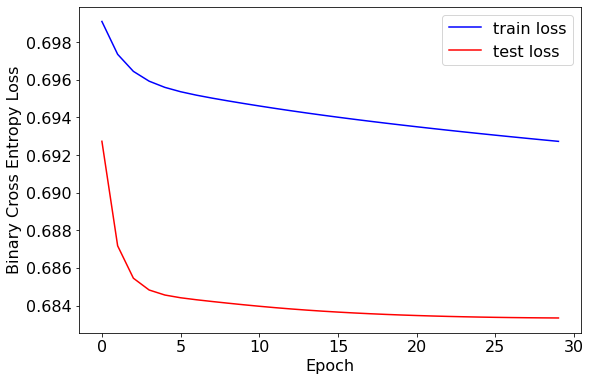

In [14]:
# 画出损失函数的变化
fig = plt.figure(figsize=(9, 6))
# 字号
plt.rcParams['font.size'] = 16
ax = fig.add_subplot(111)
ax.plot(train_loss_list, 'b', label='train loss')
ax.plot(test_loss_list, 'r', label='test loss')
ax.legend()
ax.set(xlabel='Epoch')
ax.set(ylabel='Binary Cross Entropy Loss')
plt.show()

In [15]:
# 绘制部分预测值和真实值
y_pred = y_pred.detach().numpy()
label = label.detach().numpy()

In [16]:
import sklearn.metrics as metrics

/usr/local/lib/python3.8/dist-packages/sklearn/utils/multiclass.py:13: DeprecationWarning: Please use `spmatrix` from the `scipy.sparse` namespace, the `scipy.sparse.base` namespace is deprecated.
  from scipy.sparse.base import spmatrix


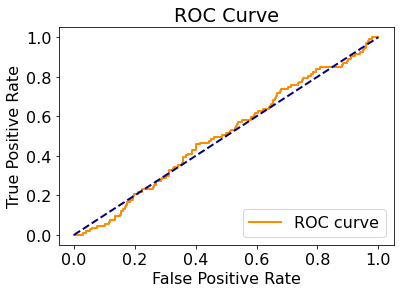

In [17]:
# 绘制ROC曲线
fpr, tpr, thresholds = metrics.roc_curve(label, y_pred)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [18]:
# 绘制混淆矩阵
y_pred = np.where(y_pred > 0.5, 1, 0)
cm = metrics.confusion_matrix(label, y_pred)

In [19]:
cm

array([[748,  88],
       [101,   6]])

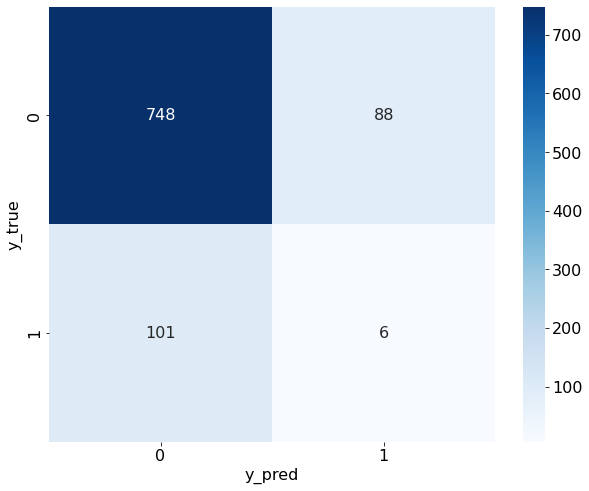

In [22]:
import seaborn as sn
plt.figure(figsize = (10,8))
sn.heatmap(cm, annot=True, cmap='Blues', fmt='d')
plt.xlabel('y_pred')
plt.ylabel('y_true')
plt.show()

In [21]:
# 保存模型
torch.save(alphanet, 'alphanet_v3_gru_classification_excess_return.pth')